# DAML Project 2

Importing relevant libraries and useful functions (from notes)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from iminuit import Minuit
import scipy

In [2]:
# Taken from the notes from two weeks ago to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
    print('\n')

## Part 1: Estimating statisical precision

Use the method of pseudo-experiments (toy Monte Carlo) to determine the expected statistical
precision with which one could measure each of the parameters with (i) 10,000 events and (ii)
100,000 events. Assume perfect detector-resolution/perfect time measurements.

The equation given for the relevant decay X -> D has the following PDF:
P proportional to (1 + Vsin(deltaM * t)) * exp(-t/tau) 

Can just make P = RHS and determine normalisation factor. Do this within a range of 0 to 10, rather than 1 to infinity, as the exponential component makes results beyond 10 mostly irrelevant (and the normalisation becomes a bit more difficult).

We need to build up the montecarlo simulation method to allow for precision determination in each of the parameters, tau, V and deltaM.

In [3]:
# Setting nominal values
tau = 1.5
V = 0.1
deltaM = 20.0

In [4]:
# define normalised probability density function

def decay_pdf(t, tau, V, deltaM):
    # calculated normalisation from range 0 to 10 for our probability equation
    # broke it up into parts, because otherwise it looks like a mess, and is really hard to read
    numerator = deltaM**2 * tau**2 + 1
    outer_denom = tau* np.exp(-10/tau)
    inner_denom = (deltaM**2 * tau**2 + V*deltaM*tau + 1)*np.exp(10/tau) - deltaM**2*tau**2 - V*deltaM*np.cos(10*deltaM)-V*np.sin(10*deltaM)-1
    norm = numerator/(outer_denom*inner_denom)
    # apply normalisation to pdf and return it
    pdf_val = norm*(1+V*np.sin(deltaM*t))*np.exp(-t/tau)
    return pdf_val

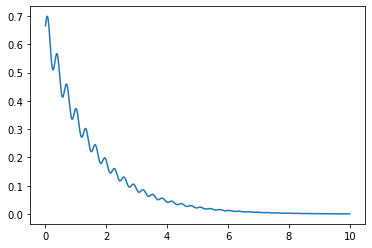

In [5]:
# Visualise the function (and to check its correct)
x_coords = np.linspace(0,10,num=1000)
y_coords = decay_pdf(x_coords, tau, V, deltaM)

plt.plot(x_coords,y_coords)
plt.show()

Plugged directly into desmos as well, looks exactly like this with the correct parameters.

Now create a box method for our PDF to create a random distribution of our function:

In [6]:
# Create a simulation function that scales to whatever value of values are needed, between 0 and upper limit
def box_sim(runs, tau, V, deltaM, upperlim):
        # Create list of pdf results
    pdf_list = []
        # Create values for upper and lower limits required by the box random generator
    l_limit = 0
    h_limit = 1
        # find f_max by taking exponent at maximum and multiplying by 1.1
        # 1.1 chosen arbitrarily as it makes it larger than max value of f
    f_max = decay_pdf(0,tau, V, deltaM) * 1.1

        # Create N random muon decays across 10 microseconds
    while (len(pdf_list) < runs):
            # generate random number within our pdf range scale between 0 and our upperlimit (of 10)
        x1 = np.random.uniform(low = l_limit, high = h_limit*upperlim)
            # Apply our pdf
        y1 = decay_pdf(x1,tau, V, deltaM)
            # generate second random number scale between 0 and our f_max
        y2 = np.random.uniform(low = l_limit, high = h_limit*f_max)

            # Check if y2 < y1. If so, add to list
        if (y2 < y1):
            pdf_list.append(x1)
        else:
            continue;
            
    return pdf_list
   
        



Define the nll function for our PDF, and use minuit to fit our pdf function to our box-method data. The number of events will change the statistical precision given, but the statistical uncertainty given by minuit will give us the expected statistical precision we can measure each of our parameters with.

In [7]:
def nll_decay(tau, V, deltaM):
    
    # Take data, will need to define this before calling the function, which will be done if you run through the notebook linearly
    x = np.array(pdf_list)
    
    # calculate the pdf value, already normalised
    y = decay_pdf(x, tau, V, deltaM)
    
    # take log of y
    y_log = np.log(y)
    
    # take negative sum
    nll = -np.sum(y_log)
    
    return nll

Generating 10,000 event PDF data

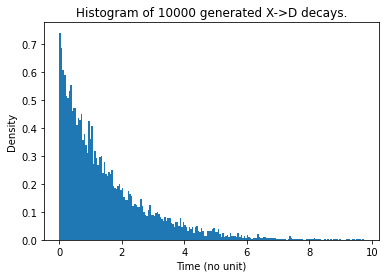

In [8]:
# Run sim with upperlimit of 10, to create a starter 'PDF' for the 
pdf_list = box_sim(10000, tau, V, deltaM, 10)

# Print histogram of pdf_list and describe the results
plt.title("Histogram of 10000 generated X->D decays.")
plt.xlabel("Time (no unit)")
plt.ylabel("Density")
plt.hist(pdf_list, bins = 200, density = True)
plt.show()



Now to use minuit with the nll to determine the parameters from this PDF:

In [9]:
# Create minuit object
m = Minuit(nll_decay, tau = 1, V = 0.5, deltaM = 21)
# Set errors
m.errors = [0.25,0.5,2]
# Define for NLL
m.errordef = 0.5
# Set limits
m.limits = [[0,3], [0,2], [10,30]]



In [10]:
# Fit and show results
result = m.migrad()

In [11]:
showIminuitResult(("tau","V","deltaM"), m)

	 tau             :  	   1.5146  +/-    0.0156
	 V               :  	   0.0839  +/-    0.0142
	 deltaM          :  	  19.9968  +/-    0.0748




And giving the statistical precision for our main parameters:

In [12]:
# Reformatting this

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 10000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(m.values["tau"],m.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(m.values["V"],m.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(m.values["deltaM"],m.errors["deltaM"]))



Statistical Errors for 10000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.515(0.016)
Matter/A-Matter asymm parameter (V) : 0.0839(0.014)
Mass difference parameter (deltaM) : 20.0(0.075)


This shows the statistical precision of our 10000 event run for our three parameters (the brackets are the statistical precision).

Our true fit values are quite close to the true values as well, within 2 sigma (on this run at least).

Now to do the same for 100000 events

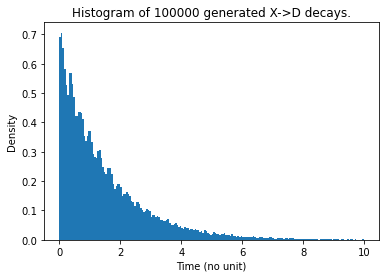

In [13]:
# 100,000 events
# Run sim with upperlimit of 10, to create a starter 'PDF' for the 
pdf_list = box_sim(100000, tau, V, deltaM, 10)

# Print histogram of pdf_list and describe the results
plt.title("Histogram of 100000 generated X->D decays.")
plt.xlabel("Time (no unit)")
plt.ylabel("Density")
plt.hist(pdf_list, bins = 200, density = True)
plt.show()



In [14]:
# Create minuit object
n = Minuit(nll_decay, tau = 1, V = 0.5, deltaM = 21)
# Set errors
n.errors = [0.25,0.5,2]
# Define for NLL
n.errordef = 0.5
# Set limits
n.limits = [[0,3], [0,2], [10,30]]



In [15]:
# Fit and show results
result = n.migrad()

In [16]:
showIminuitResult(("tau","V","deltaM"), n)

	 tau             :  	   1.4932  +/-    0.0049
	 V               :  	   0.0951  +/-    0.0045
	 deltaM          :  	  20.0517  +/-    0.0242




And giving the statistical precision for our main parameters:

In [17]:
# Reformatting this

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(n.values["tau"],n.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(n.values["V"],n.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(n.values["deltaM"],n.errors["deltaM"]))


Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.493(0.0049)
Matter/A-Matter asymm parameter (V) : 0.09514(0.0045)
Mass difference parameter (deltaM) : 20.05(0.024)


So comparing the 10,000 and 100,000 statistical precision:

In [18]:
print("Statistical precision for 10,000 and 100,000")
print("Tau (10,000): {:.2}       Tau (100,000): {:.2}".format(m.errors["tau"],n.errors["tau"]))
print("V (10,000): {:.2}         V (100,000): {:.2}".format(m.errors["V"],n.errors["V"]))
print("deltaM (10,000): {:.2}    deltaM (100,000): {:.2}".format(m.errors["deltaM"],n.errors["deltaM"]))

Statistical precision for 10,000 and 100,000
Tau (10,000): 0.016       Tau (100,000): 0.0049
V (10,000): 0.014         V (100,000): 0.0045
deltaM (10,000): 0.075    deltaM (100,000): 0.024


So we can see here (understandably) that the more events we include, the better the statistical precision (the smaller the uncertainty given by the statistical error inherent in our data distribution).

## Part 2: Estimating possible bias due to time resolution

Decay time is measured with random error with standard deviation of $\sigma = f\times \tau$ where f is some fraction.

If true decay time is $t_{true}$, then it is actually measured as t where t is distributed around $t_{true}$ with Gaussian probability distribution and standard deviation $\sigma$

So first task is determining the bias introduced to the measurement of each of the parameters when the data is subject to the resolution effect, but this is not included in the PDF used for fitting the parameters.

So rewrite the box method including this gaussian time dependence:

In [21]:
# gets a value around a certain mu within the gaussian distribution
def gaussian(mu, sig):
    value = np.random.normal(mu, sig, 1)
    return value[0]
    

# Create a simulation function that scales to whatever value of values are needed, between 0 and upper limit
def box_sim_gauss(runs, tau, V, deltaM, upperlim, fraction):
        # Create list of pdf results
    pdf_list = []
        # Create values for upper and lower limits required by the box random generator
    l_limit = 0
    h_limit = 1
        # find f_max by taking exponent at maximum and multiplying by 1.1
        # 1.1 chosen arbitrarily as it makes it larger than max value of f
    f_max = decay_pdf(0,tau, V, deltaM) * 1.1

        # Create N random muon decays across 10 microseconds
    while (len(pdf_list) < runs):
            # generate random number within our pdf range scale between 0 and our upperlimit (of 10)
        x1 = np.random.uniform(low = l_limit, high = h_limit*upperlim)
            # Apply our pdf
        y1 = decay_pdf(x1,tau, V, deltaM)
            # generate second random number scale between 0 and our f_max
        y2 = np.random.uniform(low = l_limit, high = h_limit*f_max)

            # Check if y2 < y1. If so, add to list. Include time acceptance resolution stuff here
        if (y2 < y1):
            
            # find sigma
            sigma = fraction * tau
            # find point around x1 (the mu) within sigma
            x1 = gaussian(x1, sigma)
            
            pdf_list.append(x1)
        else:
            continue;
            
    return pdf_list
   
        


Generating new data for our f = 0.01 values

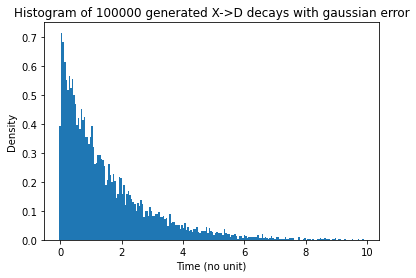

In [27]:
# Generate new data with our box_sim_gauss function, f = 0.01
pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10, 0.01)

# Print histogram of pdf_list and describe the results
plt.title("Histogram of 100000 generated X->D decays with gaussian error")
plt.xlabel("Time (no unit)")
plt.ylabel("Density")
plt.hist(pdf_list, bins = 200, density = True)
plt.show()


Fit using our previous NLL function and minuit

In [28]:
# Create minuit object
o = Minuit(nll_decay, tau = 1, V = 0.5, deltaM = 21)
# Set errors
o.errors = [0.25,0.5,2]
# Define for NLL
o.errordef = 0.5
# Set limits
o.limits = [[0,3], [0,2], [10,30]]



In [29]:
# Fit and show results
result = o.migrad()

Printing results, then comparing with previous results to get the bias.

In [32]:

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(o.values["tau"],o.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(o.values["V"],o.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(o.values["deltaM"],o.errors["deltaM"]))
print("")
print("Bias produced by the gaussian error:")
# subtract the initial 10,000 event fit values from these new ones
print("Lifetime parameter bias (Tau) : {:.4}".format(abs(o.values["tau"]-m.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(o.values["V"]-m.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format(abs(o.values["deltaM"]-m.values["deltaM"])))

Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.5(0.015)
Matter/A-Matter asymm parameter (V) : 0.08504(0.014)
Mass difference parameter (deltaM) : 20.07(0.098)

Bias produced by the gaussian error:
Lifetime parameter bias (Tau) : 0.01488
Matter/A-Matter asymm parameter (V) : 0.001136
Mass difference parameter (deltaM) : 0.07591


So we can see here the bias produced due to the introduction of the gaussian error into our data production, but not our fitting. The bias produced by the gaussian errors in our data production is less than the statistical error from the fitting, but not by a lot. It's within the same factor of all the statistical errors

No onto f = 0.03, generating the new data:

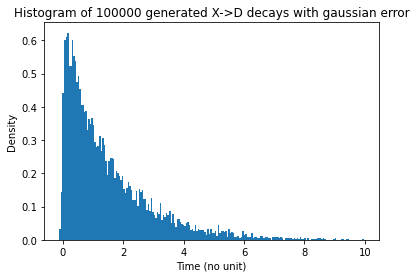

In [39]:
# Generate new data with our box_sim_gauss function, f = 0.03
pdf_list = box_sim_gauss(10000, tau, V, deltaM, 10, 0.03)

# Print histogram of pdf_list and describe the results
plt.title("Histogram of 100000 generated X->D decays with gaussian error")
plt.xlabel("Time (no unit)")
plt.ylabel("Density")
plt.hist(pdf_list, bins = 200, density = True)
plt.show()


In [40]:
# Create minuit object
p = Minuit(nll_decay, tau = 1, V = 0.5, deltaM = 21)
# Set errors
p.errors = [0.25,0.5,2]
# Define for NLL
p.errordef = 0.5
# Set limits
p.limits = [[0,3], [0,2], [10,30]]



In [41]:
# Fit and show results
result = p.migrad()

In [42]:

# {:.2} is significant digits (rounded to two)
print("Statistical Errors for 100000 events")
print("KEY   -   Value Name : Value(Expected statistical precision/error)\n")
print("Lifetime parameter (Tau) : {:.4}({:.2})".format(p.values["tau"],p.errors["tau"]))
print("Matter/A-Matter asymm parameter (V) : {:.4}({:.2})".format(p.values["V"],p.errors["V"]))
print("Mass difference parameter (deltaM) : {:.4}({:.2})".format(p.values["deltaM"],p.errors["deltaM"]))
print("")
print("Bias produced by the gaussian error:")
# subtract the initial 10,000 event fit errors from these new ones
print("Lifetime parameter bias (Tau) : {:.4}".format(abs(p.values["tau"]-m.values["tau"])))
print("Matter/A-Matter asymm parameter (V) : {:.4}".format(abs(p.errors["V"]-m.values["V"])))
print("Mass difference parameter (deltaM) : {:.4}".format(abs(p.values["deltaM"]-m.values["deltaM"])))

Statistical Errors for 100000 events
KEY   -   Value Name : Value(Expected statistical precision/error)

Lifetime parameter (Tau) : 1.509(0.016)
Matter/A-Matter asymm parameter (V) : 0.03599(0.014)
Mass difference parameter (deltaM) : 20.18(0.12)

Bias produced by the gaussian error:
Lifetime parameter bias (Tau) : 0.005947
Matter/A-Matter asymm parameter (V) : 0.06971
Mass difference parameter (deltaM) : 0.1849


The lifetime parameter bias is insignificant when compared to the statistical error here (0.016 > 0.00597), but for our M/AM and mass difference parameters this is no longer the case. 

Looking at the graph above, it is clear why this is the case. These parameters are defined by the sinusoidal components in the original function, and the gaussian noise almost wipes them out entirely, making it very difficult for our fitting process to determine their values with great accuracy.

So in this case here, we can see that the bias produced by the gaussian error is significant when compared to the statistical precisions of the fit, and are even larger in the cases of the M/AM and mass difference parameters for a fraction of f = 0.03.

In [63]:
# Repeat the whole experiment 500 times and calculate the estimate of tau for each
# This cell isn't used

def iterator(iterations, tau, V, deltaM):
        # Tau esimate array
    tau_est = []
    V_est = []
    deltaM_est = []

    for i in range(iterations):
            # Run simulation
        pdf_list = box_sim(1000, tau, V, deltaM, 10)
            # Append to list important characteristics from graph
        tau_est.append(np.mean(pdf_list))
        
        if (i%100 == 0):
            print(i)
    return tau_est


In [67]:
tau_list = iterator(10000, tau, V, deltaM)

0
100
200
300
400


KeyboardInterrupt: 

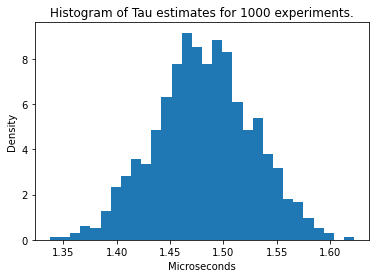

In [66]:
# Plot 
plt.title("Histogram of Tau estimates for 1000 experiments.")
plt.xlabel("Microseconds")
plt.ylabel("Density")
plt.hist(tau_list, bins = 30, density = True)
plt.show()